# Определение удельной стоимость коммерческой недвижимости

Необходимо построить модель для задачи регрессии, которая спрогнозирует ***стоимость квадратного метра*** офиса (удельная стоимость, руб./кв.м = цена предложения, руб./общая площадь, кв.м), в зависимости от общей площади, дальности от центра и других признаков.
<br>Исследование необходимо провести на выборке объектов только класса С.
<br>В наличии выборка коммерческой недвижимости в аренду: 'sales_office_c'.
<br>Выбрать лучшую модель по метрике MAE.

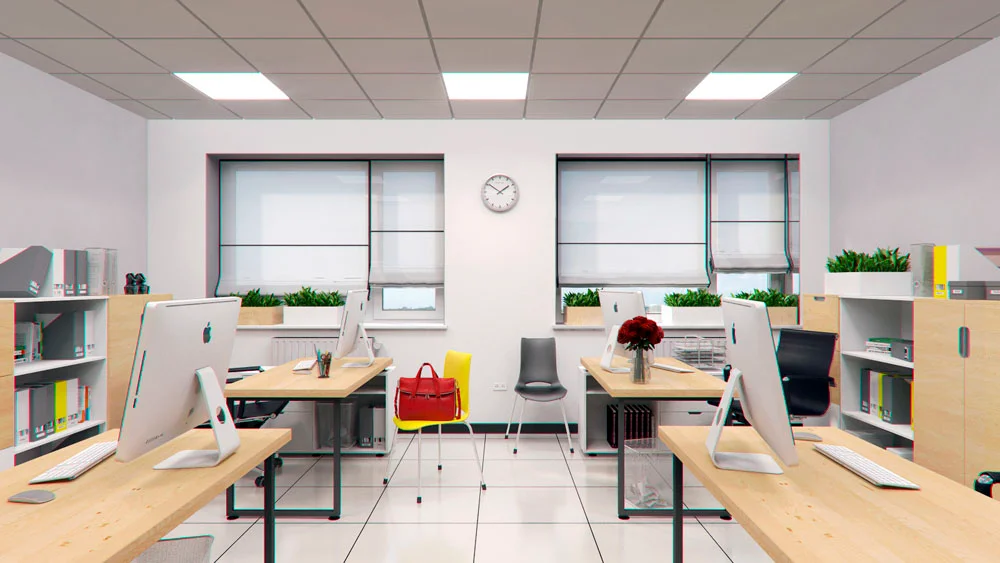

### Открытие и изучение файла¶

In [1]:
# Загрузка библиотек
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import VotingRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Путь к файлам
office=pd.read_csv('sales_office_c.csv') 
pd.options.display.max_columns = None
office.sample(3)

,id,Ссылка,Тип сделки,Город,Сегмент,Класс,Общая площадь,Этаж,Состояние отделки,Доступ,Парковка,Красная линия,Отдельный вход,Витринные окна,ЖД ветка,Отопление,Холодильная камера,ГПМ,Наличие ограждения,Адрес,Дата создания,Удельная цена,Цена,Описание,Тип здания,Ссылка на скриншот,Номер телефона,longitude,latitude,Зоны,Большие_Зоны,Кластеры,Кластеры по географии,"Расстояние до центра, м.","Ближайшая школа, м.","Ближайший детсад, м.","Ближайшее кладбище, м.","Ближайший парк, м.","Ближайшая остановка, м.","Ближайшая больница, м.","Ближайшее метро, м."
4528,886089,https://kaliningrad-region.afy.ru/kaliningrad/...,Продажа,Калининград,Офисная недвижимость,C,52,Второй и выше,NaN,NaN,Есть парковка,Красная линия,NaN,NaN,NaN,Есть,NaN,NaN,NaN,"Россия, Калининградская область, Калининград, ...",2021-01-19 00:00:00,100000,5200000,Предлагается к продаже коммерческое помещение ...,NaN,https://storage.yandexcloud.net/screenshots.in...,+7 (909) 777-24-34,NaN,NaN,;;;;;,;;;;;,;;;;;,;;;;;,590.287809,1828.21,978.16,3822.79,1250.8,466.92,940.62,NaN
6801,946565,https://afy.ru/moskva/kupit-ofis/60000992670,Продажа,Москва,Офисная недвижимость,C,565,NaN,NaN,NaN,Есть парковка,Красная линия,Есть,NaN,NaN,NaN,NaN,NaN,NaN,"Россия, Москва, Олимпийский пр-кт., 16с5",2021-01-14 00:00:00,320,180800,Лот №233067 Без Комиссии от Собственника Прода...,NaN,https://storage.yandexcloud.net/screenshots.in...,+7 (495) 410-20-83,"37,623609","55,784769",;Многофункциональные зоны-66;;;;,;Многофункциональные зоны;;;;,;3;;;;,;13;;;;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7043,933934,https://chel-region.afy.ru/chelyabinsk/kupit-o...,Продажа,Челябинск,Офисная недвижимость,C,106,Первый,NaN,NaN,Есть парковка,Красная линия,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Россия, Челябинская область, Челябинск, ул. Гю...",2021-01-24 00:00:00,"37735,84766",4000000,"Продается помещение, в непосредственной близос...",NaN,https://storage.yandexcloud.net/screenshots.in...,+7 (958) 763-69-79,"61,442367","55,131481",Спальный микрорайон 44;;;;;,Многоквартирная жилая застройка;;;;;,2;;;;;,6;;;;;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Предобработка данных¶

Необходимо провести обработку данных: по типам, на предмет пропусков и аномальных значений и т.п.

In [3]:
# Проверка типов данных
office.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13336 entries, 0 to 13335
Data columns (total 41 columns):
id                          13336 non-null int64
Ссылка                      13336 non-null object
Тип сделки                  13336 non-null object
Город                       13336 non-null object
Сегмент                     13336 non-null object
Класс                       12897 non-null object
Общая площадь               13336 non-null object
Этаж                        10386 non-null object
Состояние отделки           13 non-null object
Доступ                      909 non-null object
Парковка                    8429 non-null object
Красная линия               2869 non-null object
Отдельный вход              4824 non-null object
Витринные окна              127 non-null object
ЖД ветка                    0 non-null float64
Отопление                   2043 non-null object
Холодильная камера          2 non-null object
ГПМ                         20 non-null object
Наличие ограж

In [4]:
# Проверка выборки на предмет пропусков
office.isna().sum()

id                              0
Ссылка                          0
Тип сделки                      0
Город                           0
Сегмент                         0
Класс                         439
Общая площадь                   0
Этаж                         2950
Состояние отделки           13323
Доступ                      12427
Парковка                     4907
Красная линия               10467
Отдельный вход               8512
Витринные окна              13209
ЖД ветка                    13336
Отопление                   11293
Холодильная камера          13334
ГПМ                         13316
Наличие ограждения          12974
Адрес                           0
Дата создания                   0
Удельная цена                   0
Цена                            0
Описание                        0
Тип здания                  13223
Ссылка на скриншот           4052
Номер телефона                680
longitude                    1036
latitude                     1036
Зоны          

In [5]:
# Замена типа данных признака на object
office[['ЖД ветка']] = office[['ЖД ветка']].astype(object)

In [6]:
# Замена типа данных признака на float
office[['Общая площадь', 'Удельная цена']] = office[['Общая площадь', 'Удельная цена']].replace(",","", regex=True).astype(int)

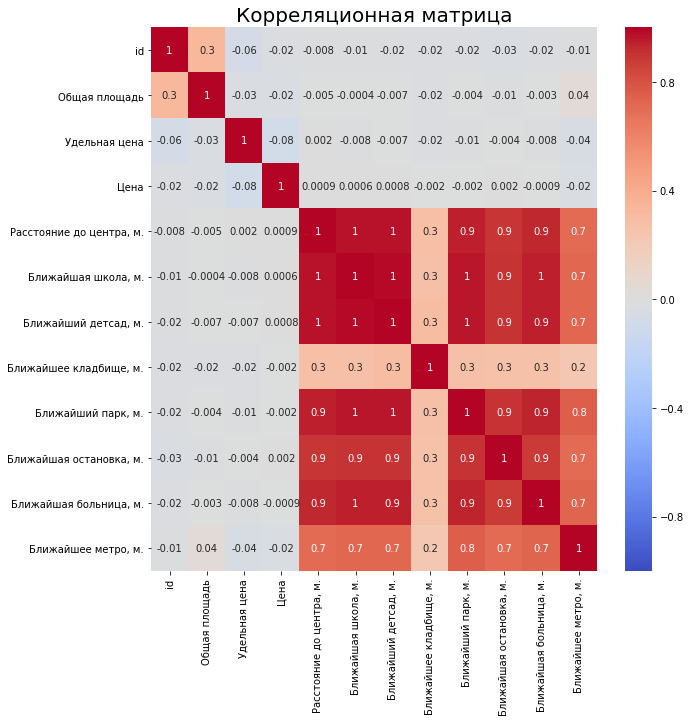

In [7]:
#Тепловая карта корреляции признаков
plt.figure(figsize = (10, 10))
sns.heatmap(office.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
plt.title('Корреляционная матрица', size = 20)
plt.show()

Корреляция с 0.7-1.0 следующих признаков в выборке: 'Ближайшая школа, м.', 'Ближайший детсад, м.', 'Ближайшее кладбище, м.', 'Ближайший парк, м.', 'Ближайшая остановка, м.', 'Ближайшая больница, м.', 'Ближайшее метро, м.', вместе с тем в категориях около 55% пропусков.
<br>Соответственно можем оставить признаки (борьба с мультиколлинеарностью): Цена, Расстояние до центра, м., остальные допустимо исключить.

In [8]:
# Отбор столбцов итоговых признаков (в т.ч. координаты в Tableau)
office_reduced = office[['Город', 
                         'Класс', 
                         'Общая площадь',
                          'Этаж',
                          'Парковка',
                          'Дата создания',
                          'Удельная цена',
                          'Цена',
                          'longitude',
                          'latitude',
                          'Расстояние до центра, м.'                          
                         ]]
office_reduced.sample(3)

,Город,Класс,Общая площадь,Этаж,Парковка,Дата создания,Удельная цена,Цена,longitude,latitude,"Расстояние до центра, м."
4951,Волгоград,C,246,Первый,Есть парковка,2021-01-24 00:00:00,2845528516,7000000,"44,567739","48,516415",21926.750000
11963,Московская область,C,35,Цоколь,Есть парковка,2021-01-29 16:27:43,68000,2380000,"38,066344","54,893467",68032.428629
3914,Казань,C,308,Первый,Стихийная наземная,2021-01-22 00:00:00,8766233594,27000000,"49,081854","55,839633",6908.350000


Для анализа выбраны офисы только класса 'C'.

<br>Они имеют следующие характеристики:
<br>1.Могут быть удалены от центральной транспортной развязки. 
<br>2.Такие здания характеризуются слабым уровнем обслуживания. 
<br>3.Здесь может не быть достаточного места для парковки или отсутствует полный набор мебели и оргтехники, необходимой для работы персонала. 
<br>4.Чаще всего такие офисы организовывают в старых постсоветских постройках, которые не были возведены с учетом всех современных требований.

In [9]:
# Получение выборки офисов только по классу 'С' 
office_reduced_c = office_reduced[office_reduced['Класс'].isin(['C'])]

In [10]:
# Проверка типов данных
office_reduced_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11727 entries, 0 to 13335
Data columns (total 11 columns):
Город                       11727 non-null object
Класс                       11727 non-null object
Общая площадь               11727 non-null int64
Этаж                        9232 non-null object
Парковка                    7465 non-null object
Дата создания               11727 non-null object
Удельная цена               11727 non-null int64
Цена                        11727 non-null int64
longitude                   10895 non-null object
latitude                    10895 non-null object
Расстояние до центра, м.    6269 non-null float64
dtypes: float64(1), int64(3), object(7)
memory usage: 1.1+ MB


In [11]:
# Просмотр основных статистических данных
office_reduced_c.describe().astype('int')

,Общая площадь,Удельная цена,Цена,"Расстояние до центра, м."
count,11727,11727,11727,6269
mean,514318338,3202706361,64424632,14097
std,1596988816,3001315579,413312440,257560
min,4,175,5500,0
25%,72,393000,3800000,1557
50%,183,2608695703,8600000,3259
75%,790,5665703320,25000000,5904
max,9942000122,9993671094,23000002560,8268535


Второстепенные признаки со следующим % NaN:
<br>Этаж- 21% (чаще '2 и выше').
<br>Парковка- 36% (чаще 'есть парковка').
<br>longitude/ latitude- 7% (чаще офисы в Москве).
<br>Расстояние до центра, м.- 47%.
<br>Заполнение признаков большинством или удаление 50% выборки будет несовсем корректно. Проводим замену на 'None', на 0 по признаку 'Расстояние до центра, м.'.

In [12]:
office_reduced_c[['Расстояние до центра, м.']] = office_reduced_c[['Расстояние до центра, м.']].fillna(0)

In [13]:
# Замена на None
office_reduced_c[['Этаж', 
                'Парковка', 
                'longitude', 
                'latitude']] = office_reduced_c[['Этаж', 
                                               'Парковка', 
                                               'longitude', 
                                               'latitude']].fillna('None')

In [14]:
office_reduced_c.isna().sum()

Город                       0
Класс                       0
Общая площадь               0
Этаж                        0
Парковка                    0
Дата создания               0
Удельная цена               0
Цена                        0
longitude                   0
latitude                    0
Расстояние до центра, м.    0
dtype: int64

Перечень гистограмм (данные с учетом выбросов) по аналитике признаков следуют далее.

In [15]:
# Количество и наименования городов
len(pd.unique(office_reduced_c['Город'])) 

46

In [16]:
office_reduced_c['Город'].unique()

array(['Москва', 'Нижний Новгород', 'Челябинск', 'Липецк', 'Архангельск',
       'Пенза', 'Астрахань', 'Самара', 'Уфа', 'Санкт-Петербург',
       'Иркутск', 'Калининград', 'Саратов', 'Петропавловск-Камчатский',
       'Кемерово', 'Ульяновск', 'Новокузнецк', 'Киров', 'Краснодар',
       'Ижевск', 'Сочи', 'Барнаул', 'Екатеринбург', 'Тюмень', 'Тольятти',
       'Чебоксары', 'Казань', 'Хабаровск', 'Омск', 'Московская область',
       'Набережные Челны', 'Волгоград', 'Красноярск', 'Томск', 'Пермь',
       'Новосибирск', 'Ростов-на-Дону', 'Южно-Сахалинск', 'Воронеж',
       'Чита', 'Курск', 'Ярославль', 'Оренбург', 'Владивосток', 'Якутск',
       'Махачкала'], dtype=object)

In [17]:
#Количество объявлений по городам; 18%- Москва
office_reduced_c['Город'].value_counts().head(3)

Москва          2161
Екатеринбург    1025
Новосибирск      940
Name: Город, dtype: int64

Text(0.5, 1.0, 'Топ-10 городов с количеством офисов в аренду')

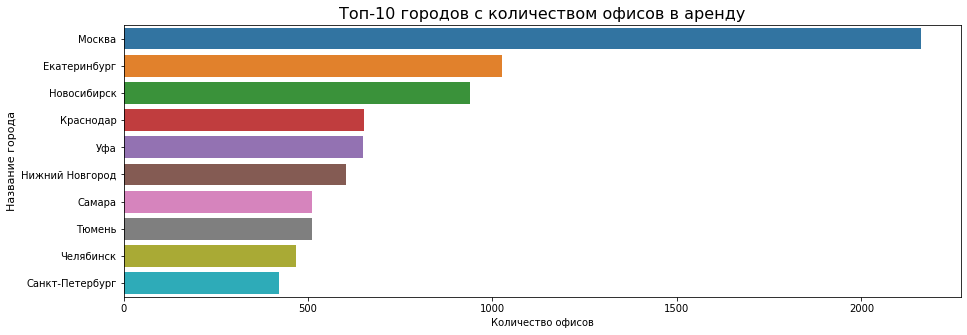

In [18]:
# Гистограмма по городам
city = (office_reduced_c['Город']).value_counts().head(10)

plt.figure(figsize=(15,5))
sns.barplot(y=city.index,x=city)
plt.xlabel('Количество офисов')
plt.ylabel('Название города', fontsize=11)
plt.title('Топ-10 городов с количеством офисов в аренду', fontsize=16)

In [19]:
# Средняя стоимость офисов по городам
pd.pivot_table(office_reduced_c,
               index=['Город'],
               values=['Цена'], aggfunc = 'mean').sort_values(by='Цена', ascending=False).head(3)

,Цена
Город,
Южно-Сахалинск,2.746811e+08
Кемерово,2.454744e+08
Москва,2.349125e+08


Text(0, 0.5, 'Средняя стоимость')

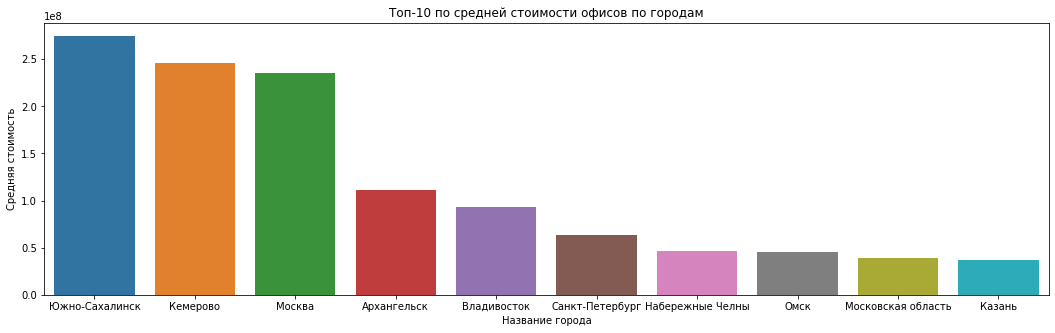

In [20]:
# Cводная таблица средней стоимости офисов и гистограмма по городам (Топ-10)
price = office_reduced_c.pivot_table(index='Город', values='Цена', aggfunc='mean').sort_values(by='Цена', ascending=False).head(10)

plt.figure(figsize=(18,5))
sns.barplot(x=price.index,y=price['Цена'])
plt.title('Топ-10 по средней стоимости офисов по городам')
plt.xlabel("Название города")
plt.ylabel("Средняя стоимость")

In [21]:
# Средняя удельная стоимость офисов по городам
pd.pivot_table(office_reduced_c,
               index=['Город'],
               values=['Удельная цена'], aggfunc = 'mean').sort_values(by='Удельная цена', ascending=False).head(3)

,Удельная цена
Город,
Владивосток,6.428485e+09
Махачкала,4.855187e+09
Чита,4.452230e+09


Text(0, 0.5, 'Средняя удельная стоимость')

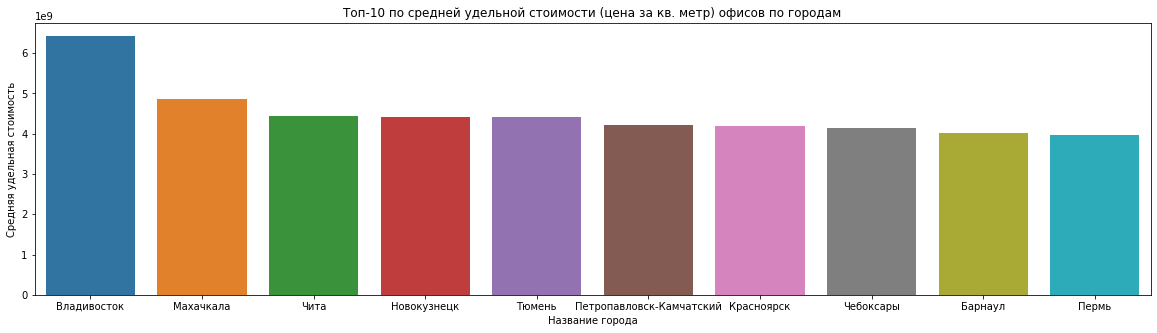

In [22]:
# Cводная таблица удельной стоимости офисов и гистограмма
price_m2 = office_reduced_c.pivot_table(index='Город', values='Удельная цена', aggfunc='mean').sort_values(by='Удельная цена', ascending=False).head(10)

plt.figure(figsize=(20,5))
sns.barplot(x=price_m2.index,y=price_m2['Удельная цена'])
plt.title('Топ-10 по средней удельной стоимости (цена за кв. метр) офисов по городам')
plt.xlabel("Название города")
plt.ylabel("Средняя удельная стоимость")

In [23]:
# Средняя площадь офисов по городам
pd.pivot_table(office_reduced_c,
               index=['Город'],
               values=['Общая площадь'], aggfunc = 'mean').sort_values(by='Общая площадь', ascending=False).head(3)

,Общая площадь
Город,
Московская область,1.545559e+09
Пермь,1.350847e+09
Ижевск,1.222970e+09


Text(0, 0.5, 'Общая площадь')

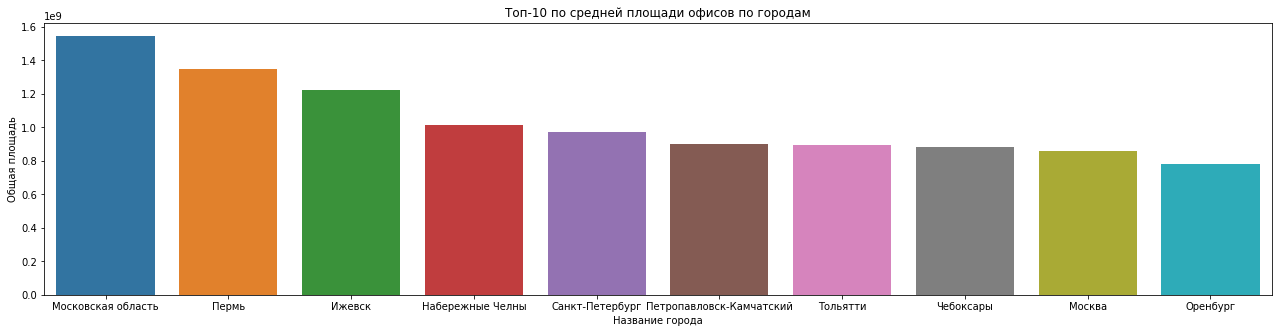

In [24]:
# Cводная таблица площади офисов и гистограмма
area = office_reduced_c.pivot_table(index='Город', values='Общая площадь', aggfunc='mean').sort_values(by='Общая площадь', ascending=False).head(10)

plt.figure(figsize=(22,5))
sns.barplot(x=area.index,y=area['Общая площадь'])
plt.title('Топ-10 по средней площади офисов по городам')
plt.xlabel("Название города")
plt.ylabel("Общая площадь")

In [25]:
# Среднее расстояние до центра офисов по городам
pd.pivot_table(office_reduced_c,
               index=['Город'],
               values=['Расстояние до центра, м.'], aggfunc = 'mean').sort_values(by='Расстояние до центра, м.', ascending=False).head(3)

,"Расстояние до центра, м."
Город,
Пенза,58842.990332
Казань,46097.360316
Московская область,45350.982626


Text(0, 0.5, 'Расстояние до центра')

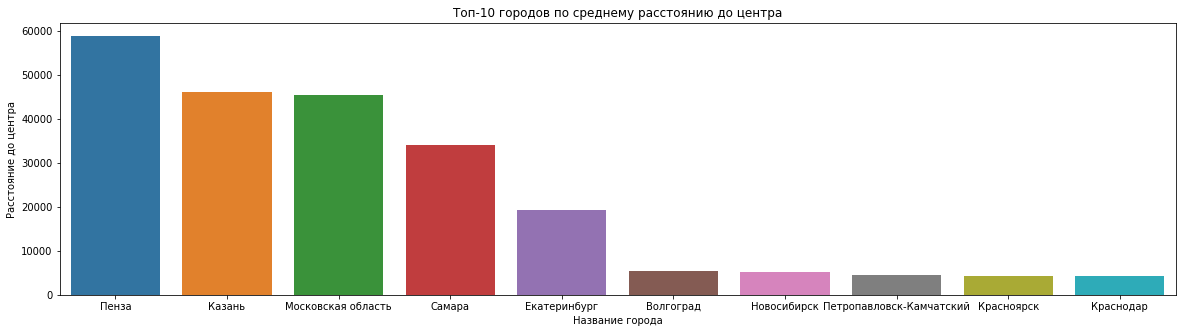

In [26]:
# Cводная таблица по расстояниям до центра от офисов и гистограмма
distance_to_center = office_reduced_c.pivot_table(index='Город', values='Расстояние до центра, м.', aggfunc='mean').sort_values(by='Расстояние до центра, м.', ascending=False).head(10)

plt.figure(figsize=(20,5))
sns.barplot(x=distance_to_center.index,y=distance_to_center['Расстояние до центра, м.'])
plt.title('Топ-10 городов по среднему расстоянию до центра')
plt.xlabel("Название города")
plt.ylabel("Расстояние до центра")

In [27]:
# Признак 'Этаж'
office_reduced_c['Этаж'].unique()

array(['Второй и выше', 'Первый', 'Цоколь', 'None', 'Подвал', 'Мансарда'],
      dtype=object)

Text(0.5, 1.0, 'Офисы в аренду: этаж')

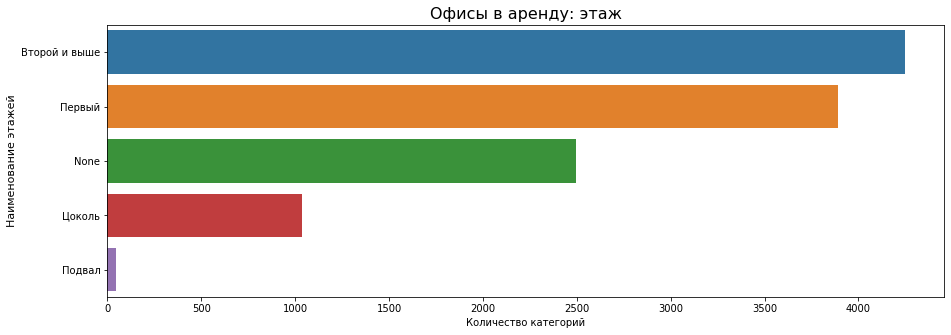

In [28]:
# Гистограмма: этаж
parking = (office_reduced_c['Этаж']).value_counts().head()

plt.figure(figsize=(15,5))
sns.barplot(y=parking.index,x=parking)
plt.xlabel('Количество категорий')
plt.ylabel('Наименование этажей', fontsize=11)
plt.title('Офисы в аренду: этаж', fontsize=16)

Дополнительно представлены графики зависимости от следующих значимых признаков: 
<br>-удельной цены от общей площади офиса;
<br>-удельной цены от расстояния до центра города.

Text(0.5, 1.01, 'Зависимость удельной цены от общей площади')

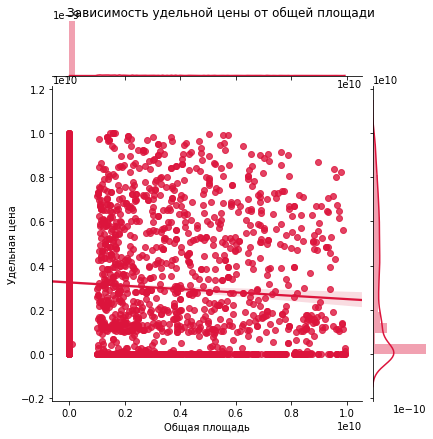

In [29]:
# Зависимость удельной цены от общей площади офиса
sns.jointplot(x=office_reduced_c["Общая площадь"], y=office_reduced_c["Удельная цена"], kind='reg', color='crimson')
plt.suptitle('Зависимость удельной цены от общей площади', y=1.01)

Text(0.5, 1.01, 'Зависимость удельной цены от расстояния до центра')

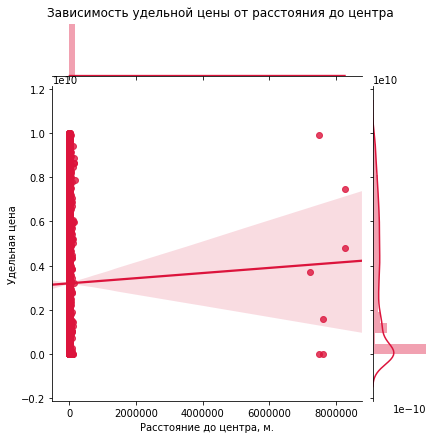

In [30]:
# Зависимость удельной цены от расстояния до центра города (допущение: около 54% пропусков в признаке)
sns.jointplot(x=office_reduced_c["Расстояние до центра, м."], y=office_reduced_c["Удельная цена"], kind='reg', color='crimson')
plt.suptitle('Зависимость удельной цены от расстояния до центра', y=1.01)

In [31]:
# Выделение отдельного столбца 'Месяц'
office_reduced_c['Дата создания'] = pd.to_datetime(office_reduced_c['Дата создания'], format = '%Y-%m-%d')
office_reduced_c['Месяц'] = office_reduced_c['Дата создания'].dt.month

In [32]:
#Количество офисов по месяцу создания объявления; 66%- Январь
office_reduced_c['Месяц'].value_counts()

1    7730
2    3712
3     217
4      68
Name: Месяц, dtype: int64

Text(0.5, 1.0, 'Динамика количества офисов (по дате создания объявления) в аренду помесячно')

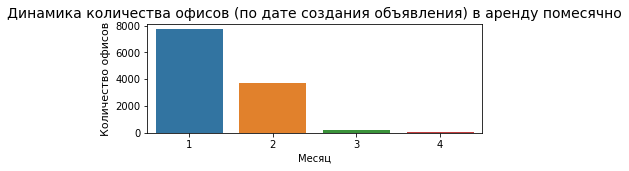

In [33]:
# Гистограмма по месяцам (Январь-Апрель т.г.)
month = office_reduced_c['Месяц'].value_counts()
plt.figure(figsize=(6,2))
sns.barplot(x=month.index,y=month)
plt.xlabel('Месяц')
plt.ylabel('Количество офисов', fontsize=11)
plt.title('Динамика количества офисов (по дате создания объявления) в аренду помесячно', fontsize=14)

In [34]:
office_reduced_c.sample(3)

,Город,Класс,Общая площадь,Этаж,Парковка,Дата создания,Удельная цена,Цена,longitude,latitude,"Расстояние до центра, м.",Месяц
7627,Уфа,C,50,Второй и выше,Есть парковка,2021-02-03 00:00:00,70000,3500000,"56,05924","54,768687",0.0,2
5751,Москва,C,455,Первый,Есть парковка,2021-01-27 20:59:55,1316483594,59900000,"37,764968","55,71093",0.0,1
4221,Москва,C,223,Второй и выше,None,2021-01-15 00:00:00,5544635,123645368,"37,539078","55,747115",0.0,1


##### Подробный разбор 3 важных признаков: 'Общая площадь', 'Удельная цена', 'Цена'. 
В них наблюдаются выбросы. Начиная с признака 'Общая площадь'- в реальности в среднем площадь предлагаемых в аренду офисов +-1500 м2 и максимально возможная в 10500 м2 (предложения найденые в открытых источниках). В данной выборке фигурируют данные до 80000м2 и выше!, поэтому оставляю срез до 100000м2, а остальное однозначно- аномальные значения.
<br>Аналогичная ситуация с признаком 'Цена'- оставляю данные стоимостью не выше 6 500 000руб.

In [35]:
# Просмотр основных статистических данных
office_reduced_c[['Общая площадь', 'Удельная цена', 'Цена']].describe().astype('int').T

,count,mean,std,min,25%,50%,75%,max
Общая площадь,11727,514318338,1596988816,4,72,183,790,9942000122
Удельная цена,11727,3202706361,3001315579,175,393000,2608695703,5665703320,9993671094
Цена,11727,64424632,413312440,5500,3800000,8600000,25000000,23000002560


Text(0.5, 1.0, 'Общая площадь офисов')

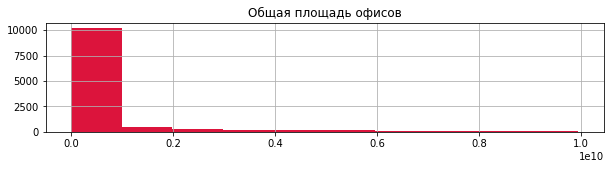

In [36]:
# Распределение по общей площади офисов
office_reduced_c['Общая площадь'].hist(bins=10, color='crimson', figsize=(10,2)).set_title('Общая площадь офисов')

Text(0.5, 1.0, 'Общая площадь офисов')

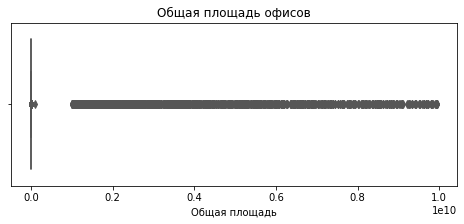

In [37]:
fig, axes = plt.subplots(figsize=(8,3))
sns.boxplot(office_reduced_c['Общая площадь'], color='turquoise').set_title('Общая площадь офисов')

In [38]:
# Перечень значенией по столбцу
set(office_reduced_c['Общая площадь'])

{3768999939,
 4,
 3128999939,
 6,
 5617999878,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 18

In [39]:
office_reduced_c['Общая площадь'].sort_values(ascending=False).head(5)

3763     9942000122
13259    9940000153
5093     9940000153
3589     9940000153
10665    9934000244
Name: Общая площадь, dtype: int64

In [40]:
office_reduced_c.loc[3763]

Город                                                 Москва
Класс                                                      C
Общая площадь                                     9942000122
Этаж                                                  Первый
Парковка                    Организованная наземная открытая
Дата создания                            2021-01-18 10:07:37
Удельная цена                                      130237625
Цена                                               129482240
longitude                                          37,820142
latitude                                           55,793379
Расстояние до центра, м.                                   0
Месяц                                                      1
Name: 3763, dtype: object

Признак 'Удельная цена' берет расчетный, после проверки признака 'Цена' на предмет аномалий.

Text(0.5, 1.0, 'Удельная стоимость офисов')

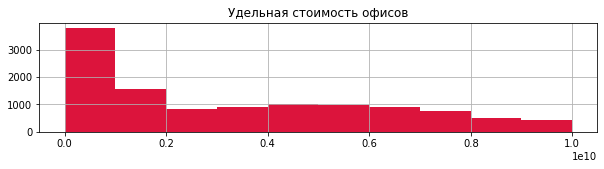

In [41]:
# Распределение по удельной стоимости офисов
office_reduced_c['Удельная цена'].hist(bins=10, color='crimson', figsize=(10,2)).set_title('Удельная стоимость офисов')

Text(0.5, 1.0, 'Удельная стоимость офисов')

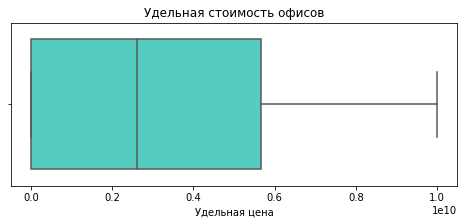

In [42]:
fig, axes = plt.subplots(figsize=(8,3))
sns.boxplot(office_reduced_c['Удельная цена'], color='turquoise').set_title('Удельная стоимость офисов')

In [43]:
office_reduced_c['Удельная цена'].sort_values(ascending=False).head(5)

10555    9993671094
10553    9993671094
4127     9993671094
4202     9991657715
116      9989010938
Name: Удельная цена, dtype: int64

Признак 'Цена' также будет проверен на предмет аномалий.

Text(0.5, 1.0, 'Стоимость офисов')

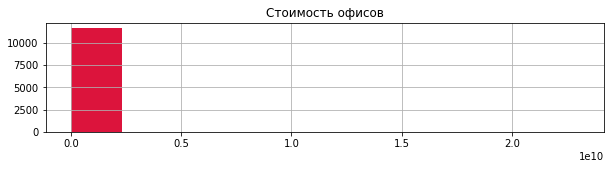

In [44]:
# Распределение по стоимости офисов
office_reduced_c['Цена'].hist(bins=10, color='crimson', figsize=(10,2)).set_title('Стоимость офисов')

Text(0.5, 1.0, 'Стоимость офисов')

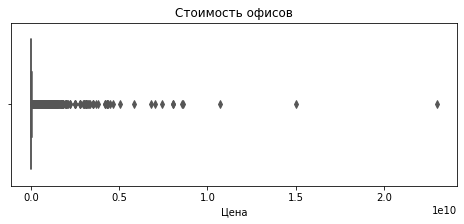

In [45]:
fig, axes = plt.subplots(figsize=(8,3))
sns.boxplot(office_reduced_c['Цена'], color='turquoise').set_title('Стоимость офисов')

In [46]:
office_reduced_c['Цена'].sort_values(ascending=False).head(3)

8433    23000002560
3554    15000000512
6621    10695300096
Name: Цена, dtype: int64

In [47]:
office_reduced_c.loc[8433]

Город                                  Кемерово
Класс                                         C
Общая площадь                               383
Этаж                              Второй и выше
Парковка                                   None
Дата создания               2021-01-19 00:00:00
Удельная цена                          60052224
Цена                                23000002560
longitude                             86,130047
latitude                              55,345811
Расстояние до центра, м.                2907.07
Месяц                                         1
Name: 8433, dtype: object

Есть офисы от 4м2- такое допустимо для интернет-бизнеса.
<br>Ряд строк подлежат удалению- при малой площади стоимость аренды указана в миллиардах! рублей в месяц (возможно это стоимость продажи). Ставлю ограничение в 6 500 000руб.- максимальная стоимость офиса в аренду класса 'C' в данный момент в Москве. Также указываю ограничение по общей площади- не более 100 000м2.

In [48]:
# Срез по признаку до 6 500 000 руб.
office_reduced_c_lim = office_reduced_c[office_reduced_c['Цена'] < 6500000]

In [49]:
office_reduced_c_lim['Цена'].sort_values(ascending=False).head(3)

2354     6499000
2442     6490000
11799    6490000
Name: Цена, dtype: int64

In [50]:
# Срез по признаку до 100 000 м2
office_reduced_c_lim = office_reduced_c_lim[office_reduced_c['Общая площадь'] < 100000]

In [51]:
office_reduced_c_lim['Общая площадь'].sort_values(ascending=False).head(3)

8442    3665
6164    3242
5821    2675
Name: Общая площадь, dtype: int64

В итоговую таблицу для ML беру 'Удельная цена_расчет', т.к. абсолютное большинство по показателю 'Удельная цена' рассчитано некоррректно (видно по отрицательной разнице сформированного столбца 'Удельная цена_разница').

In [52]:
# Пересчет столбца 'Общая площадь' для проверки
office_reduced_c_lim['Удельная цена_расчет'] = (office_reduced_c_lim['Цена'] / office_reduced_c_lim['Общая площадь'])
office_reduced_c_lim['Удельная цена_разница'] = office_reduced_c_lim['Удельная цена_расчет'] - office_reduced_c_lim['Удельная цена']
office_reduced_c_lim.sample(3)

,Город,Класс,Общая площадь,Этаж,Парковка,Дата создания,Удельная цена,Цена,longitude,latitude,"Расстояние до центра, м.",Месяц,Удельная цена_расчет,Удельная цена_разница
7074,Новосибирск,C,80,Первый,None,2021-01-20 00:00:00,41250,3300000,"82,922361","55,068345",4467.434604,1,41250.000000,0.000000e+00
1828,Нижний Новгород,C,66,Первый,Есть парковка,2021-01-15 00:00:00,43939,2899974,"44,022713","56,327955",954.160000,1,43939.000000,0.000000e+00
10675,Московская область,C,74,None,None,2021-02-12 20:01:33,5135135156,3800000,"37,869002","55,917844",47213.978838,2,51351.351351,-5.135084e+09


In [53]:
# Отбор столбцов для обучения-предсказания модели
office_ml = office_reduced_c_lim[['Город', 
                         'Общая площадь',
                          'Этаж',
                          'Удельная цена_расчет',
                          'Цена',
                          'Расстояние до центра, м.'                          
                         ]]
office_ml.sample(3)

,Город,Общая площадь,Этаж,Удельная цена_расчет,Цена,"Расстояние до центра, м."
6161,Киров,83,Первый,360.000000,29880,3482.309884
7424,Тюмень,65,Второй и выше,61538.461538,4000000,0.000000
8364,Иркутск,60,Первый,63333.333333,3800000,7581.277146


In [54]:
# Перевод признака 'Расстояние до центра' в км
office_ml['Расстояние до центра, м.'] = (office_ml['Расстояние до центра, м.']/1000)

In [55]:
# Переименование столбцов таблиц
office_ml = office_ml.rename(columns={'Город':'city', 'Общая площадь':'total_area', 
                                    'Этаж':'floor','Удельная цена_расчет':'price_per_m2',
                                    'Цена':'price','Расстояние до центра, м.':'cityCenters_nearest_km'})
office_ml.head(3)

,city,total_area,floor,price_per_m2,price,cityCenters_nearest_km
19,Москва,30,Второй и выше,139524.0,4185720,0.0
77,Москва,279,Второй и выше,3000.0,837000,0.0
105,Москва,10,Цоколь,250000.0,2500000,0.0


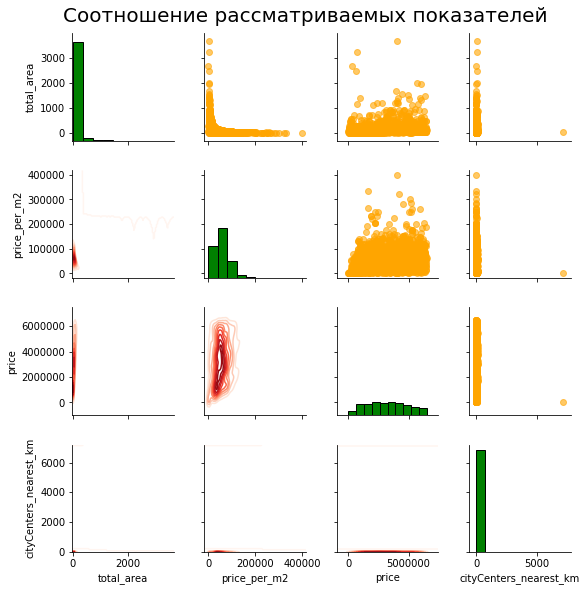

In [56]:
# Гистограмма обработанного датафрейма
grid = sns.PairGrid(data = office_ml, size = 2)
grid.map_upper(plt.scatter, color = 'orange', alpha = 0.6)
grid.map_diag(plt.hist, color = 'green', edgecolor = 'black')
grid.map_lower(sns.kdeplot, cmap = plt.cm.Reds)
plt.suptitle('Соотношение рассматриваемых показателей', size = 20, y = 1.02);

Также признак 'cityCenters_nearest_km' вызывает сомнение при 7-8 тыс.км до центра, это региональные предложения аренды- вношу правки в общую таблицу, удаляю строку '3819'.

In [57]:
office_ml['cityCenters_nearest_km'].sort_values(ascending=False).head(10)

3819     7209.973390
11950     169.097455
10860     147.515603
6291      122.991005
10656     122.092435
10655     121.977406
4012      104.755949
11962     101.111992
5355      100.294078
11961     100.148880
Name: cityCenters_nearest_km, dtype: float64

In [58]:
office_ml.loc[3819]

city                        Пенза
total_area                     27
floor                      Цоколь
price_per_m2               370.37
price                       10000
cityCenters_nearest_km    7209.97
Name: 3819, dtype: object

In [59]:
office_ml = office_ml.drop([3819])

In [60]:
# Просмотр основных статистических данных
office_ml.describe().astype('int')

,total_area,price_per_m2,price,cityCenters_nearest_km
count,4186,4186,4186,4186
mean,94,57416,3260657,3
std,166,34142,1646803,8
min,4,69,5500,0
25%,35,35016,1900000,0
50%,57,53333,3200000,1
75%,95,75000,4529475,4
max,3665,400000,6499000,169


Гистограммы с итоговой выборкой (около 30% от первоначальной) по признакам: 'total_area', 'price_per_m2', 'price'.

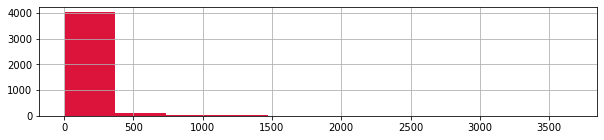

In [61]:
office_ml['total_area'].hist(bins=10, color='crimson', figsize=(10,2))

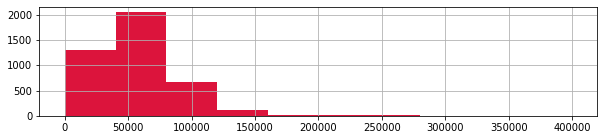

In [62]:
office_ml['price_per_m2'].hist(bins=10, color='crimson', figsize=(10,2))

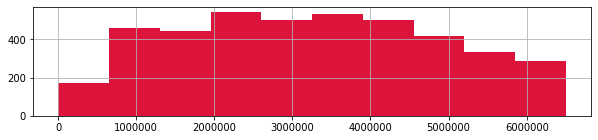

In [63]:
office_ml['price'].hist(bins=10, color='crimson', figsize=(10,2))

In [64]:
# Удаление признака (для предупреждения лика данных при предсказании моделей)
office_ml = office_ml.drop('price', axis=1)
office_ml.head(3)

,city,total_area,floor,price_per_m2,cityCenters_nearest_km
19,Москва,30,Второй и выше,139524.0,0.0
77,Москва,279,Второй и выше,3000.0,0.0
105,Москва,10,Цоколь,250000.0,0.0


##### Вывод:
В данном разделе проведена трудоемкая обработка данных. Замена типов данных по ряду признаков. Обработка пропусков данных. Проверка признаков на мультиколлинераность с помощью корреляционной матрицы- по итогу часть признаков (корреляция 0.7 и выше) убрано из данных. В выборке оставлены офисы только категории 'C'. Для итоговой выборки оставлена лишь малая часть важных признаков, переименованных на английский и без пробелов. Простроены гистограммы для проверки важных признаков: наибольшее количество обьявлений с офисами в Москве (18%), наибольшая средняя стоимость- в Южно-Сахалинске, а средняя удельная стоимость во Владивостоке, самая большая площадь офисов в МО, средние расстояния до центра до 59 км- Пенза, этажи офисов чаще 'Второй и выше', по месяцу создания объявлений Январь превалирует- 66% от всех объявлений- ряд моментов вызывают сомнение.
<br>Отдельное внимание признакам 'Общая площадь', 'Удельная цена', 'Цена'- обработаны на предмет аномальных значений. Дополнительно добавлены и рассчитаны столбцы 'Удельная цена_расчет' и разница с оригинальным столбцом- показало "мусор в данных". Таким образом в итоговую выборку попало только 30% от первоначальной выборки. Дополнительно убрана фича 'Цена'- для предупреждения лика данных при предсказании моделей.

### Подготовка данных для машинного обучения

В исследуемой выборке 2 категориальных признака (столбцы 'city' и 'floor'), для кодирования категориальных признаков применен OrdinalEncoder, также масштабируем данные с помощью StandardScaler.
Делим данные выборки на обучающую и тестовую выборку (80%-20%).

In [65]:
# Преобразование категориальных признаков в численные
office_ohe = pd.get_dummies(office_ml, drop_first= True)
office_ohe.head(3)

,total_area,price_per_m2,cityCenters_nearest_km,city_Астрахань,city_Барнаул,city_Волгоград,city_Воронеж,city_Екатеринбург,city_Ижевск,city_Иркутск,city_Казань,city_Калининград,city_Кемерово,city_Киров,city_Краснодар,city_Красноярск,city_Курск,city_Липецк,city_Махачкала,city_Москва,city_Московская область,city_Набережные Челны,city_Нижний Новгород,city_Новокузнецк,city_Новосибирск,city_Омск,city_Оренбург,city_Пенза,city_Пермь,city_Петропавловск-Камчатский,city_Ростов-на-Дону,city_Самара,city_Санкт-Петербург,city_Саратов,city_Сочи,city_Тольятти,city_Томск,city_Тюмень,city_Ульяновск,city_Уфа,city_Хабаровск,city_Чебоксары,city_Челябинск,city_Чита,city_Якутск,city_Ярославль,floor_Второй и выше,floor_Мансарда,floor_Первый,floor_Подвал,floor_Цоколь
19,30,139524.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
77,279,3000.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
105,10,250000.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [66]:
# Признаки
features = office_ohe.drop('price_per_m2', axis=1)
# Целевой признак
target = office_ohe['price_per_m2']

In [67]:
# Отделение 20% данных для тестовой выборки, на обучающую- 80%
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(3348, 50) (838, 50) (3348,) (838,)


In [68]:
# Перечень столбцов df для стандартизации
numeric = ['total_area', 'cityCenters_nearest_km']

In [69]:
# Масштабирование значений в df
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [70]:
# Преобразование выборок
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
pd.options.mode.chained_assignment = None

#print(features_train.head())
#print(features_test.head())

##### Вывод:
Окончательная обработка (OrdinalEncoder, StandardScaler, train_test_split) проведена, преобразованная выборка для машинного обучения подготовлена.

### Машинное обучение

Для обучения и получения предсказания стоимости квадратного метра офиса применим 3 модели: RandomForestRegressor, 
GradientBoostingRegressor, CatBoostRegressor + Stacking.

In [71]:
# Перечень возможных метрик регрессии
from sklearn.metrics import SCORERS
print(SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])


##### RandomForestRegressor

In [72]:
%%time

#RandomForestRegressor()
regressor = RandomForestRegressor() 
hyperparams =  [{'n_estimators':[x for x in range(10, 101, 20)], 
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error')
clf.fit(features_train, target_train)
print(clf.best_params_)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.2f for %r"% ((mean*-1), params))

MAE_rf = (max(means)*-1)

{'n_estimators': 90, 'random_state': 12345}
17090.25 for {'n_estimators': 10, 'random_state': 12345}
16636.57 for {'n_estimators': 30, 'random_state': 12345}
16585.70 for {'n_estimators': 50, 'random_state': 12345}
16537.90 for {'n_estimators': 70, 'random_state': 12345}
16491.88 for {'n_estimators': 90, 'random_state': 12345}
CPU times: user 7.05 s, sys: 46.5 ms, total: 7.1 s
Wall time: 7.11 s


In [73]:
%%time

model_rf = RandomForestRegressor(n_estimators=90, 
                      random_state=12345)
model_rf.fit(features_train, target_train)

CPU times: user 1.02 s, sys: 7.88 ms, total: 1.03 s
Wall time: 1.04 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=90,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [74]:
%%time

target_predict = model_rf.predict(features_test)

CPU times: user 25 ms, sys: 0 ns, total: 25 ms
Wall time: 23.8 ms


In [75]:
test_MAE_rf = mean_absolute_error(target_test, target_predict)
print('test_MAE of RandomForestRegressor = {0:.2f}'.format(test_MAE_rf))

test_MAE of RandomForestRegressor = 16325.34


##### GradientBoostingRegressor

In [76]:
%%time

#GradientBoostingRegressor()
regressor = GradientBoostingRegressor() 
hyperparams = [{'n_estimators': range (1, 20, 2), 
                'max_depth': range (1,5),
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error')
clf.fit(features_train, target_train)
print(clf.best_params_)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.2f for %r"% ((mean*-1), params))

MAE_gb = (max(means)*-1)

{'max_depth': 4, 'n_estimators': 19, 'random_state': 12345}
24358.07 for {'max_depth': 1, 'n_estimators': 1, 'random_state': 12345}
23144.51 for {'max_depth': 1, 'n_estimators': 3, 'random_state': 12345}
22269.41 for {'max_depth': 1, 'n_estimators': 5, 'random_state': 12345}
21652.29 for {'max_depth': 1, 'n_estimators': 7, 'random_state': 12345}
21137.73 for {'max_depth': 1, 'n_estimators': 9, 'random_state': 12345}
20752.90 for {'max_depth': 1, 'n_estimators': 11, 'random_state': 12345}
20413.86 for {'max_depth': 1, 'n_estimators': 13, 'random_state': 12345}
20170.64 for {'max_depth': 1, 'n_estimators': 15, 'random_state': 12345}
19976.03 for {'max_depth': 1, 'n_estimators': 17, 'random_state': 12345}
19830.94 for {'max_depth': 1, 'n_estimators': 19, 'random_state': 12345}
24225.94 for {'max_depth': 2, 'n_estimators': 1, 'random_state': 12345}
22762.42 for {'max_depth': 2, 'n_estimators': 3, 'random_state': 12345}
21639.50 for {'max_depth': 2, 'n_estimators': 5, 'random_state': 12345}

In [77]:
%%time

model_gb = GradientBoostingRegressor(n_estimators=19, 
                      max_depth=4, 
                      random_state=12345)
model_gb.fit(features_train, target_train)

CPU times: user 134 ms, sys: 0 ns, total: 134 ms
Wall time: 145 ms


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=19,
                          n_iter_no_change=None, presort='auto',
                          random_state=12345, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [78]:
%%time

target_predict = model_gb.predict(features_test)

CPU times: user 2.83 ms, sys: 0 ns, total: 2.83 ms
Wall time: 2.05 ms


In [79]:
test_MAE_gb = mean_absolute_error(target_test, target_predict)
print('test_MAE of GradientBoostingRegressor = {0:.2f}'.format(test_MAE_gb))

test_MAE of GradientBoostingRegressor = 17650.04


##### CatBoostRegressor

In [80]:
%%time

#CatBoostRegressor()
regressor = CatBoostRegressor(verbose=False, random_state=12345)
MAE_cb = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE of CatBoostRegressor = {0:.2f}'.format( MAE_cb))

MAE of CatBoostRegressor = 16222.33
CPU times: user 55 s, sys: 7.2 s, total: 1min 2s
Wall time: 1min 9s


In [81]:
%%time
#Обучение модели
model_cb = CatBoostRegressor()
model_cb.fit(features_train, target_train)

0:	learn: 33553.7265818	total: 1.58ms	remaining: 1.58s
1:	learn: 33214.7757400	total: 7.24ms	remaining: 3.61s
2:	learn: 32869.1709980	total: 11.9ms	remaining: 3.94s
3:	learn: 32525.1941165	total: 73.3ms	remaining: 18.2s
4:	learn: 32213.9162362	total: 79.7ms	remaining: 15.9s
5:	learn: 31927.9194402	total: 83.8ms	remaining: 13.9s
6:	learn: 31654.9632169	total: 87.6ms	remaining: 12.4s
7:	learn: 31411.1216260	total: 173ms	remaining: 21.4s
8:	learn: 31148.4691562	total: 180ms	remaining: 19.8s
9:	learn: 30901.7233914	total: 185ms	remaining: 18.3s
10:	learn: 30678.3495901	total: 270ms	remaining: 24.3s
11:	learn: 30447.9835858	total: 274ms	remaining: 22.5s
12:	learn: 30223.8545056	total: 279ms	remaining: 21.2s
13:	learn: 30009.5477085	total: 283ms	remaining: 19.9s
14:	learn: 29818.4404832	total: 369ms	remaining: 24.2s
15:	learn: 29606.1276829	total: 374ms	remaining: 23s
16:	learn: 29410.3178197	total: 380ms	remaining: 22s
17:	learn: 29236.0519856	total: 465ms	remaining: 25.4s
18:	learn: 29072.

In [82]:
%%time
#Предсказание на тестовой выборке
target_predict = model_cb.predict(features_test)

CPU times: user 10 ms, sys: 116 µs, total: 10.1 ms
Wall time: 6.03 ms


In [83]:
#MAE на тестовой выборке
test_MAE_cb = mean_absolute_error(target_test, target_predict)
print('test_MAE of CatBoostRegressor = {0:.2f}'.format(test_MAE_cb))

test_MAE of CatBoostRegressor = 16807.42


##### Stacking

In [84]:
%%time
#Обучение модели VotingRegressor()
rf = RandomForestRegressor(n_estimators=90, random_state=12345)
gb = GradientBoostingRegressor(n_estimators=19, max_depth=4, random_state=12345)
cb = CatBoostRegressor(verbose=False, random_state=12345)

model_vr = VotingRegressor(estimators=[
    ('rf', rf), ('gb', gb), ('cb', cb)])

model_vr.fit(features_train.values, target_train.values)

CPU times: user 12.1 s, sys: 1.39 s, total: 13.5 s
Wall time: 15.1 s


VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=90, n_jobs=None,
                                                   oob_score=False,
                                                   random_state=12345,
                     

In [85]:
%%time

regressor = VotingRegressor(estimators=[
    ('rf', rf), ('gb', gb), ('cb', cb)])
MAE_vr = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE of VotingRegressor = {0:.2f}'.format( MAE_vr))

MAE of VotingRegressor = 16152.98
CPU times: user 59.1 s, sys: 7.48 s, total: 1min 6s
Wall time: 1min 12s


In [86]:
%%time
#Предсказание на тестовой выборке
target_predict = model_vr.predict(features_test)

CPU times: user 33.6 ms, sys: 249 µs, total: 33.9 ms
Wall time: 28 ms


In [87]:
#MAE на тестовой выборке
test_MAE_vr = mean_absolute_error(target_test, target_predict)
print('test_MAE of VotingRegressor = {0:.2f}'.format(test_MAE_vr))

test_MAE of VotingRegressor = 16293.89


In [88]:
# Свод по метрикам
index = ['RandomForestRegressor',
         'GradientBoostingRegressor',
         'CatBoostRegressor',
        'VotingRegressor']
data = {'MAE на обучении':[MAE_rf,
                     MAE_gb,
                     MAE_cb,
                     MAE_vr],
        'MAE на тесте':[test_MAE_rf,
                        test_MAE_gb,
                        test_MAE_cb,
                        test_MAE_vr]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,MAE на обучении,MAE на тесте
RandomForestRegressor,16491.883791,16325.335698
GradientBoostingRegressor,17544.668495,17650.041365
CatBoostRegressor,16222.325856,16807.416965
VotingRegressor,16152.977950,16293.888972


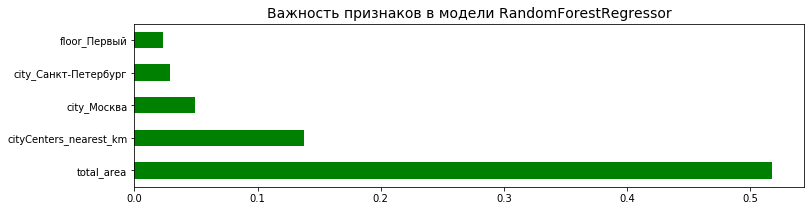

In [89]:
# График feature_importances_
feat_importances = pd.Series(model_rf.feature_importances_, index=features_train.columns)
plt.figure(figsize=(12,3))
feat_importances.nlargest().plot(kind='barh', color='green')

plt.title('Важность признаков в модели RandomForestRegressor', size=14);

Данные по проекту также можно посмотреть в визуализации Tableau: https://public.tableau.com/app/profile/verak2261/viz/Office_ml/Bord_ok?publish=yes

##### Вывод:
Для предсказания стоимость квадратного метра офисов для оценки применялась метрика МАЕ на следующих моделях  RandomForestRegressor, GradientBoostingRegressor, CatBoostRegressor, VotingRegressor.
<br>По важности признаков на трейне лучшей модели RandomForestRegressor с большим отрывом лидирует закономерно 'total_area'.
<br>Получилось повысить производительность моделей за счет их кумулятивного эффекта на стекинге: VotingRegressor с максимальной метрикой на тесте- 16294 руб./ трейне- 16153 руб. в сравнении с лучшей моделью RandomForestRegressor на тесте- 16325 руб./ трейне- 16492 руб. (модель ошибается на 16000 руб., при условии, что средняя стоимость квадратного метра по выборке- 53000-57000 руб.).